# Pytorch karakter felismerés
#### Source: https://www.youtube.com/watch?v=raIYLr0tnRA&t=1245s

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import copy
from sklearn.model_selection import train_test_split

In [2]:
#GPU használata ha lehetséges
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#Dataset letőltése
cdata = torchvision.datasets.EMNIST(root='eminst', 
                                    split='letters', download=True)

In [4]:
print(cdata.classes)
print(str(len(cdata.classes))+ ' classes')

print('\nData size:')
print(cdata.data.shape)

images= cdata.data.view([124800,1,28,28]).float()
print('\nTensor data:')
print(images.shape)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])


In [5]:
print( torch.sum(cdata.targets==0))

torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [6]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [7]:
letterCat = cdata.classes[1:]

labels = copy.deepcopy(cdata.targets)-1
print(labels.shape)

print(torch.sum(labels==0))
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

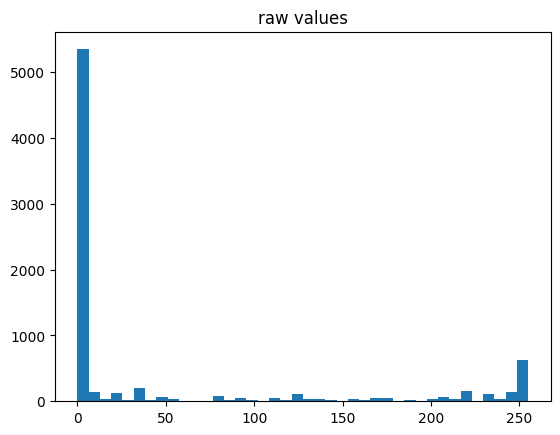

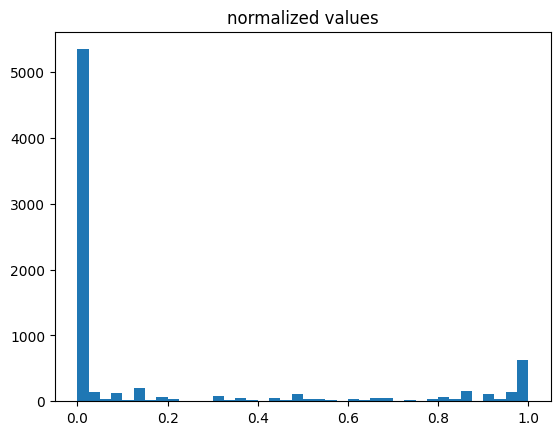

In [8]:
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('raw values')
plt.show()

images /= torch.max(images)

plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('normalized values')
plt.show()

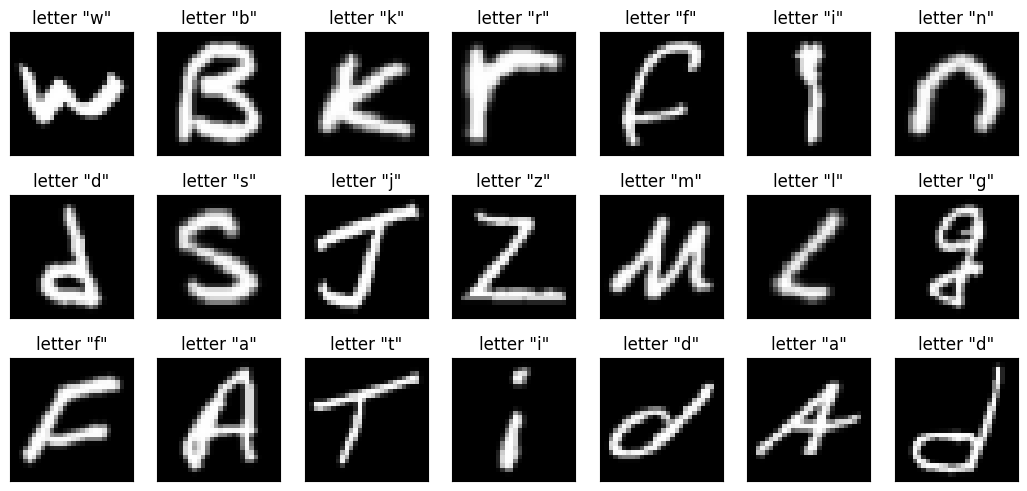

In [9]:
#Példa adatok
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
    pic = np.random.randint(images.shape[0])
    
    I = np.squeeze( images[pic,:,:])
    letter =letterCat[labels[pic]]
    
    ax.imshow(I.T, cmap='gray')
    ax.set_title('letter "%s"'%letter)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [10]:
train_data, test_data ,train_labels, test_labels = train_test_split(images, labels, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data, test_labels)

batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [11]:
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


In [20]:
def makeTheNet(printtoggle=False):
    
    class emnistnet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()
            
            self.print = printtoggle
            
            #1st convolution layer
            self.conv1 = nn.Conv2d(1,6,3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(6)
            
            #2nd convoluton layer
            self.conv2 = nn.Conv2d(6,6,3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(6)
            
            self.fc1 = nn.Linear(7*7*6,50)
            self.fc2 = nn.Linear(50,26)
            
        def forward(self,x):
            if self.print: print(f'Input: {list(x.shape)}')
                
            x = F.max_pool2d(self.conv1(x),2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print: print(f'first CPR block{list(x.shape)}')
                
            x = F.max_pool2d(self.conv2(x),2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print: print(f'second CPR block{list(x.shape)}')
                
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))
            if self.print: print(f'vectorized: {list(x.shape)}')
                
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)
            if self.print: print(f'final output: {list(x.shape)}')
                
            return x
        
    net = emnistnet(printtoggle)
    loss = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(net.parameters(), lr=.001)
    return net,loss,optimizer


In [21]:
net,loss,optimizer = makeTheNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

print('\nOutput size:')
print(yHat.shape)

L = loss(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(L)

AttributeError: Can't pickle local object 'makeTheNet.<locals>.emnistnet'

In [14]:
def train():
    epochs = 25
    net, loss, optimizer = makeTheNet()
    net.to(device)
    
    trainloss = torch.zeros(epochs)
    testloss = torch.zeros(epochs)
    trainerr = torch.zeros(epochs)
    testerr = torch.zeros(epochs)
    
    for epochi in range(epochs):
        net.train()
        batchloss = []
        batcherr = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            
            yHat = net(X)
            L = loss(yHat, y)
            
            optimizer.zero_grad()
            L.backward()
            optimizer.step()
            
            batchloss.append(L.item())
            batcherr.append(torch.mean((torch.argmax(yHat, axis=1) != y).float()).item())
            
        trainloss[epochi] = np.mean(batchloss)
        trainerr[epochi] = 100 * np.mean(batcherr)
        
        net.eval()
        X, y = next(iter(test_loader))
        X = X.to(device)
        y = y.to(device)
            
        with torch.no_grad():
            yHat = net(X)
            L = loss(yHat, y)
            
        testloss[epochi] = L.item()
        testerr[epochi] = torch.mean((torch.argmax(yHat, axis=1) != y).float()).item() * 100
        
    return trainloss, testloss, trainerr, testerr, net

In [15]:
trainloss, testloss, trainerr, testerr, net= train()

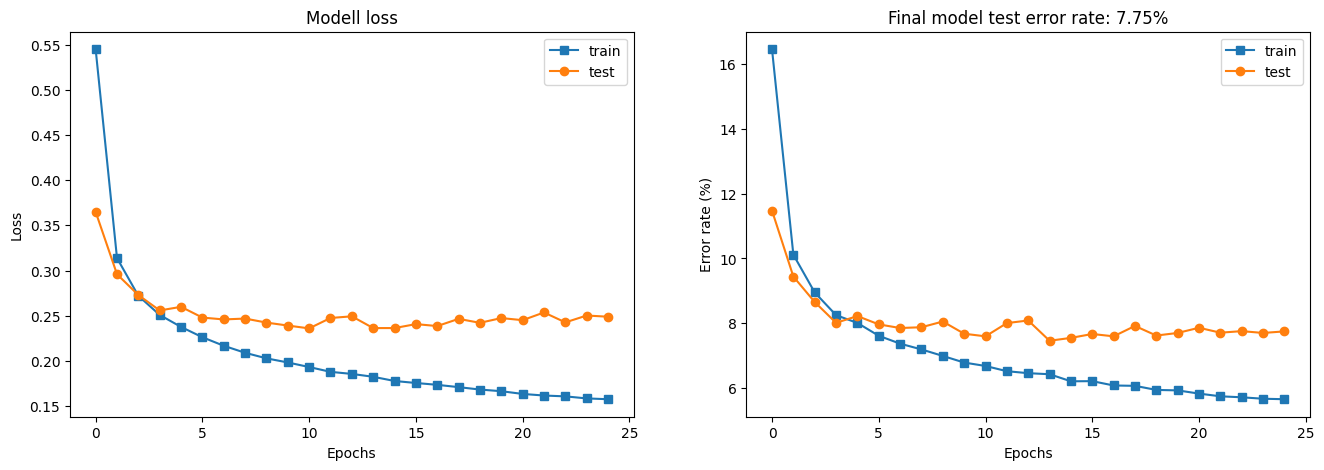

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainloss, 's-', label='train')
ax[0].plot(testloss, 'o-', label='test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Modell loss')
ax[0].legend()

ax[1].plot(trainerr, 's-', label='train')
ax[1].plot(testerr, 'o-', label='test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rate (%)')
ax[1].set_title(f'Final model test error rate: {testerr[-1]:.2f}%')
ax[1].legend()

plt.show()

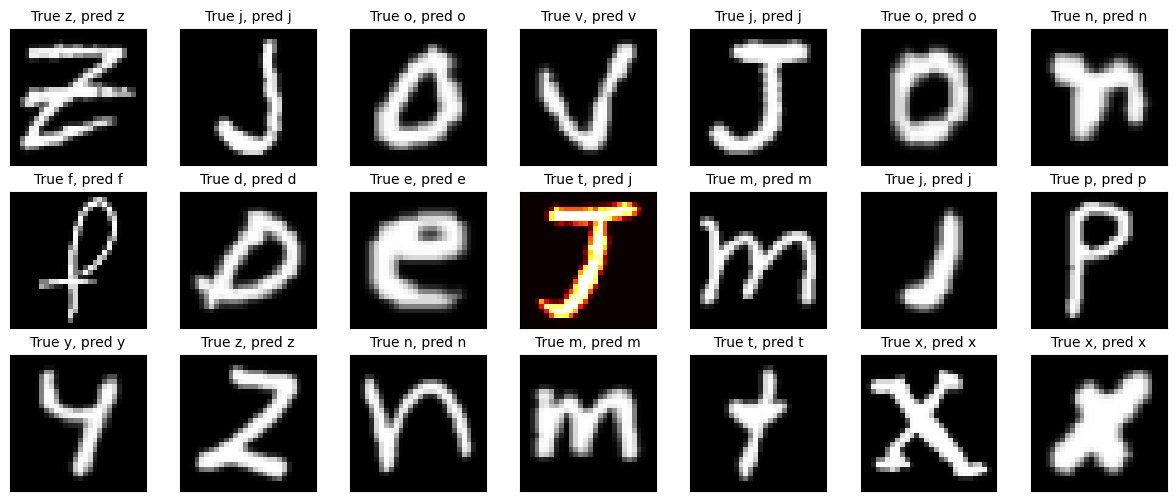

In [17]:
X,y = next(iter(test_loader))
X= X.to(device)
y = y.to(device)
yHat = net(X)

randex = np.random.choice(len(y), size=21, replace=False)
fig,axs = plt.subplots(3,7, figsize=(15,6))

for i,ax in enumerate(axs.flatten()):
    I = np.squeeze( X[randex[i],0,:,:]).cpu()
    trueletter = letterCat[ y[randex[i]]]
    predletter = letterCat[ torch.argmax(yHat[randex[i],:])]
    
    col = 'gray' if trueletter==predletter else 'hot'
    
    ax.imshow(I.T, cmap=col)
    ax.set_title('True %s, pred %s' %(trueletter,predletter),fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [25]:
torch.save(net.state_dict(), 'Data/Model/torch.pth')